<a href="https://colab.research.google.com/github/mratanusarkar/twitter-sentiment-analysis/blob/feature%2Ftweet-analysis-and-inference/Notebooks/Tweet_Analysis_and_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Analysis and Inference

## Install Packages

In [1]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import re
import string
import traceback
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

## Define Helper Functions

In [3]:
def get_tweets(query: str, limit: int) -> pd.DataFrame:
    """
    Scrape tweets from twitter based on input search query
    Arguments:
        :param query: twitter search query as per https://twitter.com/search?q=
        :param limit: number of tweets you want to scrape
    Returns:
        :return: a pandas dataframe with the tweets
    """
    tweets = []
    columns = [
        'id',
        'date',
        'username',
        'content',
        'view_count',
        'like_count',
        'reply_count',
        'retweet_count',
        'quote_Count',
        'url'
    ]
    try:
        print("scraping tweets ...")
        twitter_search = sntwitter.TwitterSearchScraper(query).get_items()
        for tweet in tqdm(twitter_search, total=limit):
            if len(tweets) == limit:
                break
            else:
                data = [
                    tweet.id,
                    tweet.date,
                    tweet.user.username,
                    tweet.rawContent,
                    tweet.viewCount,
                    tweet.likeCount,
                    tweet.replyCount,
                    tweet.retweetCount,
                    tweet.quoteCount,
                    tweet.url
                ]
                tweets.append(data)
        df = pd.DataFrame(tweets, columns=columns)
        return df
    except Exception:
        print(traceback.print_exc())
        return pd.DataFrame()

In [4]:
def refine_text(tweet: str) -> str:
    tweet_words = []
    for word in tweet.split(' '):
        if word.startswith('@') and len(word) > 1:
            # remove mentions
            word = ""
        elif word.startswith('http') or word.startswith('www'):
            # remove links
            word = ""
        tweet_words.append(word)
    refined_tweet = " ".join(tweet_words)
    
    # remove punctuations
    exclude = set(string.punctuation)
    refined_tweet = ''.join(ch for ch in refined_tweet if ch not in exclude)

    # remove non-printable characters (remove non english characters)
    printable = set(string.printable)
    refined_tweet = ''.join(filter(lambda x: x in printable, refined_tweet))
    
    return refined_tweet

In [5]:
def word_counter(tweet: str, counter: Counter) -> Counter:
    word_list = tweet.split(' ')
    word_count = Counter(word_list)
    return counter + word_count

In [6]:
def remove_common_words(counter: Counter, force_exclude_words=[]) -> Counter:
    # https://www.textfixer.com/tutorials/common-english-words.php
    common_words = [
        "", "tis", "twas", "a", "able", "about", "across", "after", "aint", 
        "all", "almost", "also", "am", "among", "an", "and", "any", "are", "arent", 
        "as", "at", "be", "because", "been", "but", "by", "can", "cant", "cannot", 
        "could", "couldve", "couldnt", "dear", "did", "didnt", "do", "does", 
        "doesnt", "dont", "either", "else", "ever", "every", "for", "from", "get", 
        "got", "had", "has", "hasnt", "have", "he", "hed", "hell", "hes", "her", 
        "hers", "him", "his", "how", "howd", "howll", "hows", "however", "i", 
        "id", "ill", "im", "ive", "if", "in", "into", "is", "isnt", "it", "its", 
        "its", "just", "least", "let", "like", "likely", "may", "me", "might", "mightve", 
        "mightnt", "most", "must", "mustve", "mustnt", "my", "neither", "no", "nor", 
        "not", "of", "off", "often", "on", "only", "or", "other", "our", "own", "rather", 
        "said", "say", "says", "shant", "she", "shed", "shell", "shes", "should", 
        "shouldve", "shouldnt", "since", "so", "some", "than", "that", "thatll", 
        "thats", "the", "their", "them", "then", "there", "theres", "these", "they", 
        "theyd", "theyll", "theyre", "theyve", "this", "tis", "to", "too", "twas", 
        "us", "wants", "was", "wasnt", "we", "wed", "well", "were", "were", "werent", 
        "what", "whatd", "whats", "when", "when", "whend", "whenll", "whens", "where", 
        "whered", "wherell", "wheres", "which", "while", "who", "whod", "wholl", 
        "whos", "whom", "why", "whyd", "whyll", "whys", "will", "with", "wont", 
        "would", "wouldve", "wouldnt", "yet", "you", "youd", "youll", "youre", "youve", "your"]
    letters = [
        "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", 
        "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z" 
    ]
    numbers = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

    for word in common_words:
        try:
            counter.pop(word.lower())
            counter.pop(word.upper())
            counter.pop(word.title())
        except:
            pass
    for word in letters + numbers:
        try:
            counter.pop(word.lower())
            counter.pop(word.upper())
        except:
            pass
    if len(force_exclude_words) > 0:
        for word in force_exclude_words:
            try:
                counter.pop(word)
                counter.pop(word.lower())
                counter.pop(word.upper())
                counter.pop(word.title())
            except:
                pass
    return counter

In [7]:
def generate_word_cloud(rawData: pd.DataFrame, force_exclude_words=[]):
    print("processing data & counting words ...")
    counter = Counter({})
    for tweet_content in tqdm(rawData.content, total=len(rawData.index)):
        refined_tweet = refine_text(tweet_content)
        counter = word_counter(refined_tweet, counter)
    counter = remove_common_words(counter, force_exclude_words)
    print("top 10 words:", counter.most_common(10))

    print("generating word cloud ...")
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(counter)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.annotate(
        "@mratanusarkar", xy=(0.98, 0.02), xycoords='axes fraction', 
        ha='right', va='bottom', fontsize=12, color='white', alpha=0.8, weight='bold'
    )
    fig = plt.gcf()
    plt.show()
    return fig

## Runner

scraping tweets ...


  0%|          | 0/10000 [00:00<?, ?it/s]

processing data & counting words ...


  0%|          | 0/10000 [00:00<?, ?it/s]

top 10 words: [('ISRO', 4149), ('SSLVD2', 1684), ('launch', 1100), ('SSLV', 878), ('India', 804), ('Space', 667), ('satellites', 642), ('amp', 570), ('space', 541), ('isro', 530)]
generating word cloud ...


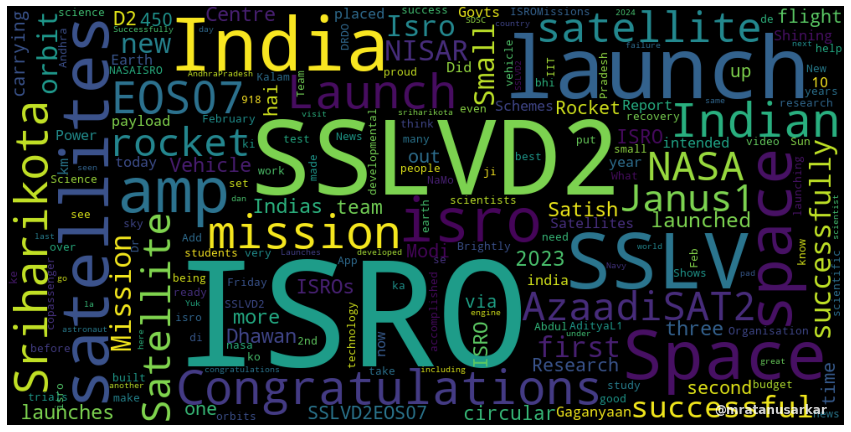

In [8]:
# set parameters
topic_title = 'SSLVD2'
query = 'ISRO OR #SSLVD2 OR #ISRO'
limit = 10_000
exclude_words = []

# scrape tweets and generate wordcloud
rawData = get_tweets(query, limit)
plt_fig = generate_word_cloud(rawData, exclude_words)

## Export Data

In [9]:
# Save Tweets
rawData.to_csv(topic_title + ".csv")
rawData.to_json(topic_title + ".json")
rawData.to_parquet(topic_title + ".parquet")

In [10]:
# Save Word Cloud
plt_fig.savefig(topic_title + ".png", bbox_inches='tight', dpi=300)